# CSCA 5642: Introduction to Deep Learning week4 assignment

Author: Nobuo Takizawa  
GitHub Repository: https://github.com/nobuyo/intro-to-dl/tree/main/week4

# Description of the Problem

> Briefly describe the challenge problem and NLP.

## Challenge Overview

* This week's challenge is a kaggle competition called Natural Language Processing with Disaster Tweets.
* The task is to identify tweets posted on twitter that are related to an actual disaster.

## Background

* Disaster relief agencies and news organizations are interested in programmatic monitoring of Twitter, as people around the world have smartphones and can share what they see on Twitter in real time.
* However, only real disasters need to be filtered out, as figurative language can be used, such as “it looks like it's burning up,” referring to a sunset, etc.

## Task Evaluation

* The task should output label 1 if it is a real disaster, and 0 otherwise.
* F1 score is used for evaluation.

$$F_{1} = 2 \times \frac{precision \times recall}{precision + recall}$$

## About Natural Language Processing (NLP)

NLP is a technology that allows computers to understand, process, and generate human language. The field is expanding from traditional methods to applications in machine learning, and there are tasks for extracting and transforming information from vast amounts of text and speech data.
Natural language is characterized by its sequential nature and its meaning changes significantly depending on the relationship between the words before and after them. This indicates that language data can be treated as a type of time series data. Therefore, in the field of NLP, a method suitable for processing series data is required.

RNNs, which are treated in this report, are neural networks suitable for handling series data. In recent years, Transformer models have replaced RNNs as the mainstream in NLP, but RNNs are still applied in some cases to time-series data and simple NLP tasks. Therefore, understanding the relationship between NLP and RNNs is important for the development and application of natural language processing.

---

Kaggle. (n.d.). Natural language processing with disaster tweets. Retrieved February 16, 2025, from https://www.kaggle.com/c/nlp-getting-started/overview

# Load libraries, dataset

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import nltk
from nltk.corpus import stopwords

In [4]:
df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')

# Description of the Data

>  Describe the size, dimension, structure, etc., of the data.
>
> 

First let's check the size of data, number of null values and number of duplicated rows.

* There are 5 features, and 7613 rows.
* The columns `keyword` and `location` have missing values.

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [23]:
df.duplicated().sum()

0

Next, let's take a quick look at training data.

* text looks like the body of a tweet
* target is obviously a label
* keyword and location are empty as far as I can see now.

In [78]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


And what are contained for `location` and `keyword` column?

The `location` field contains strings that are not standardized in format, such as 'World Wide!!'. This suggests that it is user-entered data, similar to the bio section on Twitter.

In [8]:
df.dropna()['location'].unique()[:10]

array(['Birmingham', 'Est. September 2012 - Bristol', 'AFRICA',
       'Philadelphia, PA', 'London, UK', 'Pretoria', 'World Wide!!',
       'Paranaque City', 'Live On Webcam', 'milky way'], dtype=object)

The `keyword` field represents keywords associated with the tweet, such as "ablaze," "accident," "army," etc.

In [9]:
df.dropna()['keyword'].unique()[:10]

array(['ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army'], dtype=object)

# EDA

In this section, let's take a closer look at the data.

First, we'll examine the distribution of labels. The distribution is somewhat skewed, with more instances of label 0, but it is not significantly imbalanced.

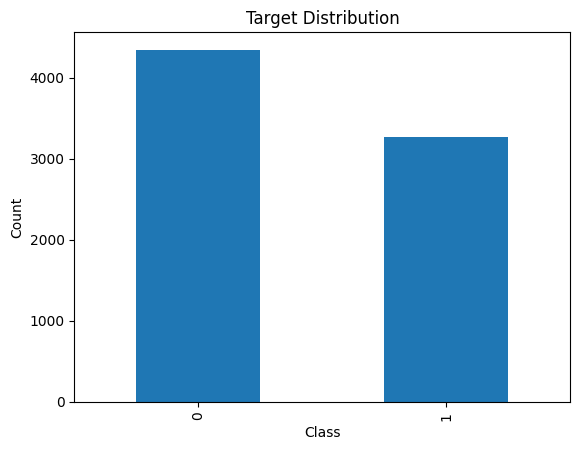

In [11]:
df["target"].value_counts().plot(kind="bar")
plt.title("Target Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

Next, let's examine the statistics of text length.
By splitting the text into words and counting them, we find that the average length is 15 words, with a maximum of 31 words.

In [4]:
df["text_length"] = df["text"].apply(lambda x: len(x.split()))
df["text_length"].describe()

count    7613.000000
mean       14.903586
std         5.732604
min         1.000000
25%        11.000000
50%        15.000000
75%        19.000000
max        31.000000
Name: text_length, dtype: float64

Let's plot a histogram of the previously counted word lengths.
The distribution appears to have a bell shape.

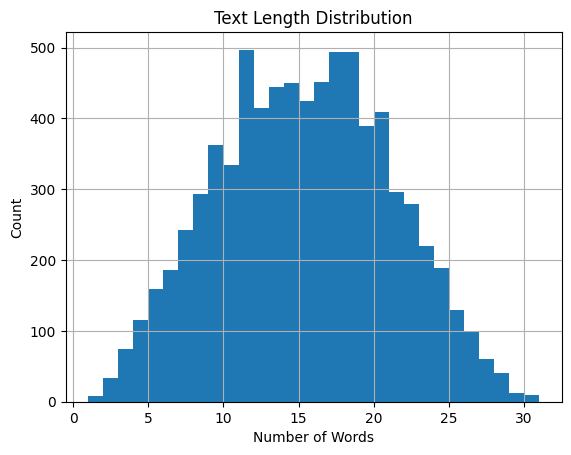

In [21]:
df["text_length"].hist(bins=30)
plt.title("Text Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Count")
plt.show()

I am interested in the distribution of character counts. Since the counts are discrete, I have examined them using the Poisson distribution and the negative binomial distribution (nbinom). The negative binomial distribution (nbinom) is a better fit. From this, the character count can be interpreted as the number of words added before the information is conveyed.

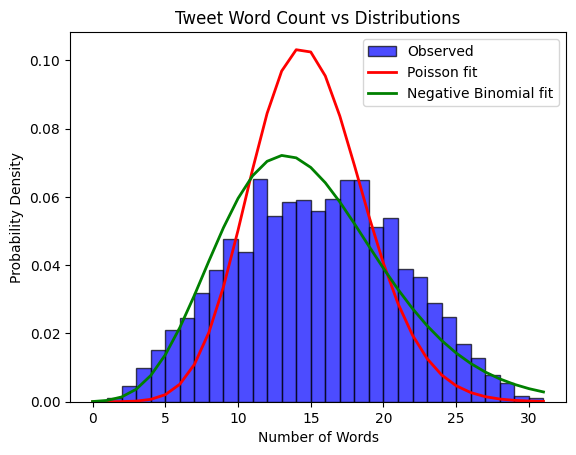

In [37]:
from scipy.stats import poisson

x = np.arange(0, df["text_length"].max() + 1)

# compute poisson
lambda_poisson = df["text_length"].mean()
poisson_probs = poisson.pmf(x, lambda_poisson) * len(df)

# compute nbinom
mean_length = df["text_length"].mean()
var_length = df["text_length"].var()
r = (mean_length ** 2) / (var_length - mean_length)
p = mean_length / var_length
nbinom_probs = nbinom.pmf(x, r, p) * len(df)

# plot
plt.hist(df["text_length"], bins=30, alpha=0.7, color="blue", edgecolor="black", density=True, label="Observed")
plt.plot(xp, poisson_probs / len(df), "r-", label="Poisson fit", lw=2)
plt.plot(xb, nbinom_probs / len(df), "g-", label="Negative Binomial fit", lw=2)
plt.xlabel("Number of Words")
plt.ylabel("Probability Density")
plt.title("Tweet Word Count vs Distributions")
plt.legend()
plt.show()

The distribution for each target does not show any clear differences that could aid in classification.

- target = 1 is more concentrated around the center, meaning that extremely short or long tweets are relatively fewer.
- target = 0 has more short and long tweets, but since the center is also densely populated, the distribution of target = 1 is completely covered by target = 0.

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


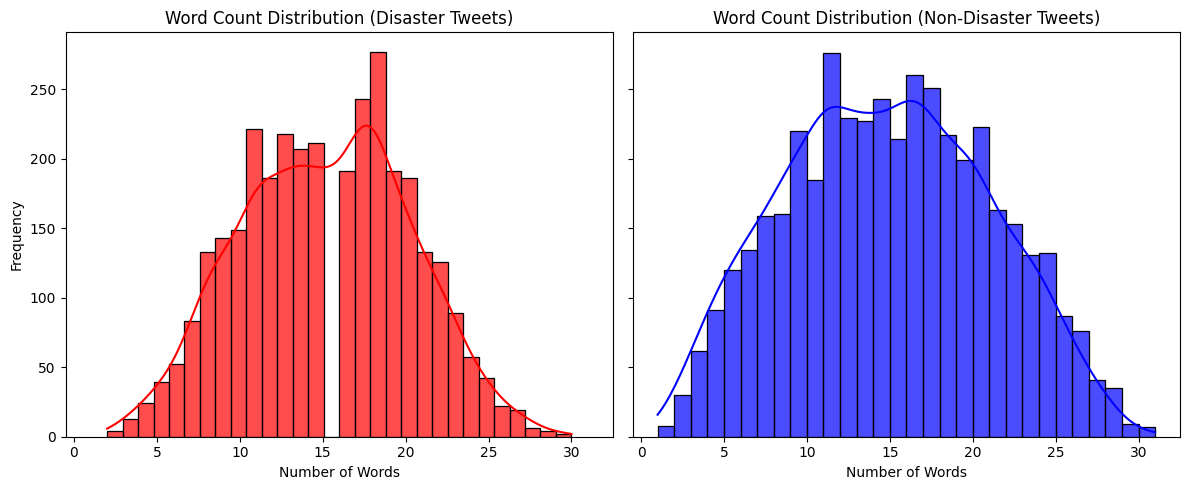

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

# target=1
sns.histplot(df[df["target"] == 1]["text_length"], bins=30, color="red", alpha=0.7, kde=True, ax=axes[0])
axes[0].set_xlabel("Number of Words")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Word Count Distribution (Disaster Tweets)")

# target=0
sns.histplot(df[df["target"] == 0]["text_length"], bins=30, color="blue", alpha=0.7, kde=True, ax=axes[1])
axes[1].set_xlabel("Number of Words")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Word Count Distribution (Non-Disaster Tweets)")

plt.tight_layout()
plt.show()

I applied clustering to the text transformed using a TF-IDF vectorizer.
The clusters overlap significantly, suggesting that linear separation is difficult.

Since TF-IDF weights words based on frequency information, if PCA had clearly separated the data, it would indicate the presence of distinct vocabulary groups within the text.
However, this hypothesis was not supported, meaning that no clear genre-based separation exists in the vocabulary used.

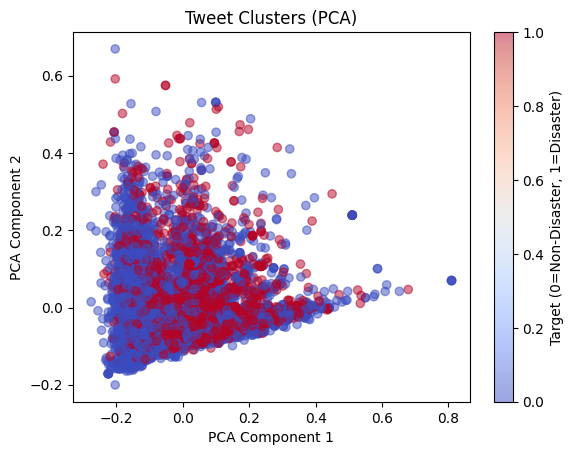

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df["text"])

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df["target"], alpha=0.5, cmap="coolwarm")
plt.title("Tweet Clusters (PCA)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Target (0=Non-Disaster, 1=Disaster)")
plt.show()

Next, I'll check for tweet-specific elements, such as replies, URLs, and hashtags.
I'll examine the proportion of tweets that contain these elements.

After counting these elements for each target, I found that mentions are less frequent when target = 1.
However, this difference does not seem significant enough to be a useful feature for classification.

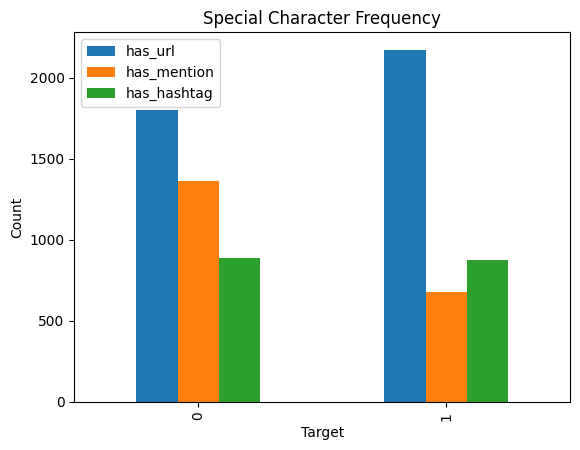

In [60]:
df["has_url"] = df["text"].apply(lambda x: 1 if re.search(r"http[s]?://", x) else 0)
df["has_mention"] = df["text"].apply(lambda x: 1 if "@" in x else 0)
df["has_hashtag"] = df["text"].apply(lambda x: 1 if "#" in x else 0)

df[["target", "has_url", "has_mention", "has_hashtag"]].groupby('target').sum().plot(kind="bar")
plt.title("Special Character Frequency")
plt.xlabel("Target")
plt.ylabel("Count")
plt.show()

# Data Preprocessing

To generate input data for the model, the following preprocessing steps will be applied:

## Cleaning
- Convert text to lowercase.
- Remove URLs, mentions, and hashtags.
- Expand contractions.
- Normalize numbers.

## Convert to Model Input
- Tokenize the text.
- Apply padding to ensure uniform input length.







In [5]:
contractions = {
    "can't": "cannot", "won't": "will not", "n't": " not",
    "'re": " are", "'s": " is", "'d": " would", "'ll": " will",
    "'t": " not", "'ve": " have", "'m": " am"
}

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text) # remove URLs
    text = re.sub(r"@\w+", "", text)  # remove @mentions
    text = re.sub(r"#\w+", "", text)  # remove #hashtags
    
    # replace contraction
    for contraction, full_form in contractions.items():
        text = text.replace(contraction, full_form)

    # replace digits
    text = re.sub(r"\d+", " NUM ", text)

    # replace any symbols
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)

    # replace redundant whitespace
    text = re.sub(r"\s+", " ", text).strip()  # 余分な空白を削除

    # remove stop words
    words = text.split()
    words = [word for word in words if word not in stop_words]
    text = ' '.join(words)
    
    return text

df['cleaned_text'] = df['text'].apply(clean_text)
df['cleaned_text'].head()

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


0                    deeds reason may allah forgive us
1                forest fire near la ronge sask canada
2    residents asked ishelter place notified office...
3    NUM NUM people receive evacuation orders calif...
4               got sent photo ruby smoke pours school
Name: cleaned_text, dtype: object

In [19]:
# vocab size of cleaned data
unique_words = set(" ".join(df["cleaned_text"]).split())
unique_word_count = len(unique_words)
print(unique_word_count)

# max number of words
print(max(df["cleaned_text"].apply(lambda x: len(x.split()))))

13349
28


In [8]:
# Build input data for NN
# Tokenize / Convert to sequence with padding

vocab_size = 13000
max_words = 30

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(df["cleaned_text"])

def generate_input(x, tokenizer):
    # convert texts to sequences (list of word ids)
    seq = tokenizer.texts_to_sequences(x)
    
    # padding sequences
    seq = pad_sequences(seq, maxlen=max_words, padding='post')

    return seq

X = generate_input(df["cleaned_text"], tokenizer)
print("\nTokenized & Padded Sequences:")
print(X)


Tokenized & Padded Sequences:
[[3952  678   55 ...    0    0    0]
 [  96    5  124 ...    0    0    0]
 [1482 1357 5815 ...    0    0    0]
 ...
 [   2    2    2 ...    0    0    0]
 [  16  923 2770 ...    0    0    0]
 [ 110  105  389 ...    0    0    0]]


# Model Architecture

In this section, I will explain the structure of the models used in this experiment.  

As a baseline model, I will use a neural network with GRU (Gated Recurrent Unit).  
For comparison, I will also evaluate a CNN-based model.

## Strategy to Convert to Matrix

Before discussing the model structure, I will explain the strategy used to convert text data into numerical representations.  
Since neural networks perform numerical computations, they cannot directly process raw text data. Therefore, some form of numerical transformation is necessary.  

In this experiment, I will tokenize the text, convert tokens into numerical IDs, and input them into Keras' Embedding layer.


## Tokenization and Embedding

### Tokenization
Tokenization is the process of splitting text into individual words (tokens). For example:

```python
text = "I have a cat"
tokens = ["I", "have", "a", "cat"]
```

In actual preprocessing, punctuation and stop words are often removed, but I am omitting that step here.

### **Numerical Encoding**
Each token is mapped to a unique numerical ID:

```python
tokens = ["I", "have", "a", "cat"]
word_to_id = {
    "I": 1,
    "have": 2,
    "a": 3,
    "cat": 4,
    "dog": 5,
}
```

Using this dictionary, the original text can be converted into a list of word IDs:

```python
tokenized_texts = [
    ["I", "have", "a", "cat"],
    ["I", "have", "a", "dog"],
]

encoded_texts = [
    [1, 2, 3, 4],  # "I have a cat"
    [1, 2, 3, 5],  # "I have a dog"
]
```

### **Embedding Layer**
Although we now have a numerical representation, word IDs are categorical values, so they cannot be directly used for training a neural network effectively.  
This is where the Embedding layer comes in.

The Embedding layer converts each word ID into a dense vector representation.  
Internally, it maintains a matrix of shape (vocab_size, embedding_dim), where each row corresponds to a word ID.

Example:

```python
embedding_matrix = [
    [0.12, 0.34, ...],  # ID: 1 = "I"
    [0.45, -0.57, ...], # ID: 2 = "have"
    # ...
    [0.11, 0.38, ...],  # ID: 5 = "dog"
]
```

By using this mapping, the tokenized input is transformed into dense word vectors:

```python
# Input for NN
# Shape: (batch_size, input_length, embedding_dim)
input_matrix = [
    [
        [0.12, 0.34, ...],  # ID: 1 = "I"
        [0.45, -0.57, ...], # ID: 2 = "have"
        [0.81, 0.11, ...],  # ID: 3 = "a"
        [0.38, -0.94, ...], # ID: 4 = "cat"
        ... # More words or padding if necessary
    ],
    ... # More samples
]
```

## **How Word Vectors Are Determined**

So far, I've explained how `Embedding` converts word IDs into vectors. But how are these word vectors determined?

In this approach, the embedding matrix is initialized randomly at the start. During training, it is updated through backpropagation, just like weights in a dense layer.

This means that word embeddings are optimized together with the classification task, allowing the model to learn meaningful word representations as it trains.

## Pre-trained word embeddings and difference with the Embedding layer

Methods like Word2Vec pre-train the mapping between words and vectors. Word2Vec learns word embeddings based on context, using either a Continuous Bag-of-Words (CBOW) or Skip-gram model (Řehůřek, n.d.).

These approaches are separate from neural network training and generate word vectors based on co-occurrence patterns. This means the word embeddings are determined independently of specific tasks like text classification.

In contrast, the Embedding layer used in this experiment optimizes word vectors during neural network training. While both methods learn appropriate representations for words, they differ in when and how the learning process occurs.

## **References**
- Keras Team. (n.d.). **Embedding layer**. Keras. [https://keras.io/api/layers/core_layers/embedding/](https://keras.io/api/layers/core_layers/embedding/)  
- Řehůřek, R. (n.d.). **Word2Vec tutorial**. Gensim. [https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html)

## Baseline Model: RNN with GRU

As the baseline model, I chose an RNN with GRU. The reasons for this choice are explained below.

### Why RNN?

In text data, word order is crucial. If the entire input text is treated as a single feature vector, the context is lost.  
RNNs and their variants are designed to preserve sequential dependencies. Unlike MLPs, which compute outputs with a simple linear transformation:

$$
y = Wx + b
$$

RNNs incorporate a time-dependent structure:

$$
h_t = \tanh(W_{h}h_{t-1} + W_{x}x_{t} + b)
$$
$$
y_t = W_{y}h_{t} + b_{y}
$$

For example, if `"I love cats"` is input into the network after embedding, an MLP would process the entire input at once. In contrast, an RNN processes words sequentially, updating hidden states in order:  
first `"I"`, then `"love"`, and finally `"cats"`, allowing it to capture context.

### Gradient Vanishing Problem

RNNs face the gradient vanishing problem.  
Since hidden states update sequentially, the error signal propagates backward through time, causing multiplications of small gradients.

For a sequence of three words, the learning process follows:

$$
\begin{align}
    h_1 &= \tanh(W_{h}h_{0} + W_{x}x_{1} + b) \\
    h_2 &= \tanh(W_{h}h_{1} + W_{x}x_{2} + b) \\
    h_3 &= \tanh(W_{h}h_{2} + W_{x}x_{3} + b) \\
    L_3 &= -\log \hat{y}_3(w_4)
\end{align}
$$

During backpropagation, the gradient update involves multiple terms:

$$
\begin{align}
\frac{\partial L_3}{\partial W_h} &=
\frac{\partial L_3}{\partial h_3} 
\frac{\partial h_3}{\partial W_h} 
+ 
\frac{\partial L_3}{\partial h_3} 
\frac{\partial h_3}{\partial h_2} 
\frac{\partial h_2}{\partial W_h}
+ 
\frac{\partial L_3}{\partial h_3} 
\frac{\partial h_3}{\partial h_2} 
\frac{\partial h_2}{\partial h_1} 
\frac{\partial h_1}{\partial W_h}
\end{align}
$$

Since \(\partial h_t/\partial h_{t-1} < 1\), gradients shrink over long sequences, making weight updates ineffective.

LSTM and GRU solve this issue by modifying how hidden states are updated using gating mechanisms.

### Why GRU?

GRU introduces update gate \(z_t\) and reset gate \(r_t\). The hidden state is controlled by \(z_t\), which takes values between 0 and 1:

$$
h_t = (1-z_t) \odot h_{t-1} + z_t \odot \tilde{h}_t
$$

During backpropagation, when \(z_t = 0\), \(\partial h_t/\partial h_{t-1} = 1\), effectively skipping some layers and mitigating gradient vanishing.

$$
\frac{\partial h_t}{\partial h_{t-1}} = (1-z_t) + z_t \frac{\partial \tilde{h}_t}{\partial h_{t-1}}
$$

LSTM and GRU share similar mechanisms, but LSTM has higher complexity and more parameters. GRU was designed as a lighter alternative, with fewer gates and smaller parameter sizes, making it a practical choice for this model.

The final model structure is shown in the following code.

---

**References**  

- University of Washington. (2020). *Recurrent Neural Networks (RNNs) [Lecture slides]*. Retrieved from https://courses.cs.washington.edu/courses/csep517/20wi/slides/csep517wi20-RNNs.pdf  
- Guerzhoy, M. (n.d.). *Recurrent neural networks and gated recurrent units (GRUs) [Lecture slides]*. Retrieved from https://www.cs.toronto.edu/~guerzhoy/321/lec/W09/rnn_gated.pdf

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Embedding

embedding_dim = 100

baseline_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    GRU(units=64, return_sequences=False),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
], name="rnn")

baseline_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

baseline_model.build(input_shape=(None, max_words))

# show model summary
baseline_model.summary()

Model: "rnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 30, 100)             │       1,300,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 64)                  │          31,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,336,097 (5.10 MB)

 Trainable params: 1,336,097 (5.10 MB)

 Non-trainable params: 0 (0.00 B)

## Trying CNN as a Second Model for Comparison with RNN

To compare with the RNN model, I will experiment with CNN as the second model.  
As previously explained, RNNs process input sequentially, capturing contextual dependencies across time steps.

In this model, the data is first embedded in the same manner as in the RNN model. However, instead of processing the sequence step-by-step, a [Conv1D layer](https://keras.io/api/layers/convolution_layers/convolution1d/) is applied over the embedded matrix.  

Unlike RNNs, which explicitly preserve word order and long-term dependencies, CNNs apply convolutional filters that focus on local patterns, treating the embedded word matrix as a structured spatial representation rather than a pure sequence.

This approach allows CNNs to capture n-gram-like local patterns while reducing the computational burden of sequential dependencies.

In [10]:
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dropout

cnn_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    Conv1D(128, 3, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
], name="cnn")

cnn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

cnn_model.build(input_shape=(None, max_words))

# show model summary
cnn_model.summary()

Model: "cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 30, 100)             │       1,300,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 28, 128)             │          38,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 128)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,346,849 (5.14 MB)

 Trainable params: 1,346,849 (5.14 MB)

 Non-trainable params: 0 (0.00 B)

## Training Models

In this section, I will train the model that was built earlier.

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, df['target'], test_size=0.2, random_state=187)

print(f"Training data's shape: {X_train.shape}")
print(f"Validation data's shape: {X_val.shape}")

Training data's shape: (6090, 30)
Validation data's shape: (1523, 30)


In [12]:
baseline_history = baseline_model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), verbose=1)

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.5647 - loss: 0.6866 - val_accuracy: 0.5923 - val_loss: 0.6777
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.5653 - loss: 0.6855 - val_accuracy: 0.5923 - val_loss: 0.6770
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.5625 - loss: 0.6863 - val_accuracy: 0.7255 - val_loss: 0.6098
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.7900 - loss: 0.4849 - val_accuracy: 0.8096 - val_loss: 0.4452
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.9040 - loss: 0.2516 - val_accuracy: 0.7932 - val_loss: 0.5220
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.9521 - loss: 0.1367 - val_accuracy: 0.7689 - val_loss: 0.6535
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.9710 - loss: 0.0845 - val_accuracy: 0.7485 - val_loss: 0.9072
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.9739 - loss: 0.0586 - val_accu

In [13]:
def plot_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    # 1. Accuracy
    axs[0].plot(history.history['accuracy'], label='Train Accuracy')
    axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axs[0].set_title('Model Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend()

    # 2. Loss
    axs[1].plot(history.history['loss'], label='Train Loss')
    axs[1].plot(history.history['val_loss'], label='Validation Loss')
    axs[1].set_title('Model Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].legend()

    plt.show()

When plotting the training progress, the following graph was obtained.
There is a point where the validation loss worsens, suggesting possible overfitting.

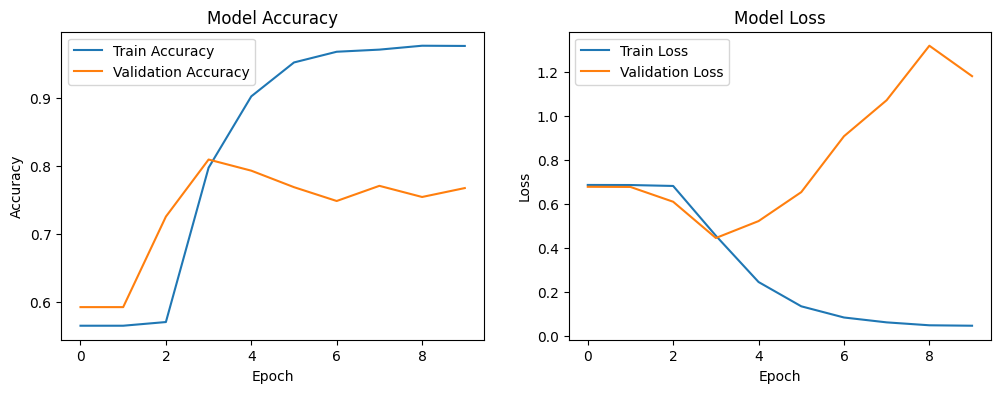

In [14]:
plot_history(baseline_history)

In [84]:
cnn_history = cnn_model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), verbose=1)

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.6154 - loss: 0.6346 - val_accuracy: 0.7840 - val_loss: 0.4830
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8855 - loss: 0.2954 - val_accuracy: 0.7833 - val_loss: 0.4886
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9568 - loss: 0.1431 - val_accuracy: 0.7610 - val_loss: 0.6301
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9702 - loss: 0.0945 - val_accuracy: 0.7754 - val_loss: 0.7107
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9798 - loss: 0.0630 - val_accuracy: 0.7505 - val_loss: 0.7700
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9812 - loss: 0.0575 - val_accuracy: 0.7649 - val_loss: 0.7742
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9831 - loss: 0.0500 - val_accuracy: 0.7400 - val_loss: 0.8032
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9815 - loss: 0.0454 - val_accu

When plotting the training results, the following pattern emerges.
From the first epoch, validation loss consistently increases, indicating that the model is not learning effectively, even when given the same input data.

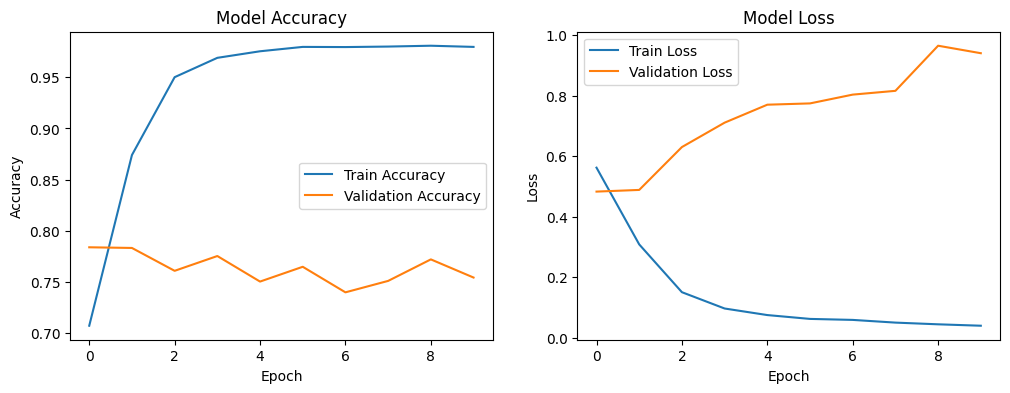

In [85]:
plot_history(cnn_history)

# Results and Analysis

In this section, I will analyze the prediction results of the trained model.

In [50]:
from sklearn.metrics import confusion_matrix, roc_curve, f1_score, roc_auc_score

def plot_confusion_matrices_comparison(
    y_true_1, y_pred_1, y_true_2, y_pred_2,
    model_name_1="Model 1", model_name_2="Model 2"
):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Model 1
    cm_1 = confusion_matrix(y_true_1, y_pred_1)
    sns.heatmap(cm_1, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"], ax=axes[0])
    axes[0].set_title(f"{model_name_1} - Confusion Matrix")
    axes[0].set_xlabel("Predicted Label")
    axes[0].set_ylabel("True Label")

    # Model 2
    cm_2 = confusion_matrix(y_true_2, y_pred_2)
    sns.heatmap(cm_2, annot=True, fmt='d', cmap='Oranges', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"], ax=axes[1])
    axes[1].set_title(f"{model_name_2} - Confusion Matrix")
    axes[1].set_xlabel("Predicted Label")
    axes[1].set_ylabel("True Label")

    plt.tight_layout()
    plt.show()

According to the plot of the confusion matrix for each model, the CNN model appears to classify almost nothing correctly.

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


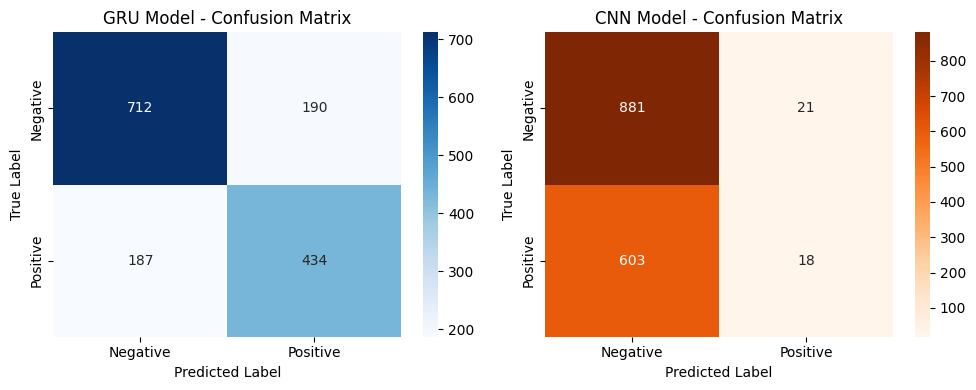

In [100]:
y_pred_rnn = (baseline_model.predict(X_val) > 0.5).astype(int).flatten()
y_pred_cnn = (cnn_model.predict(X_val) > 0.5).astype(int).flatten()

plot_confusion_matrices_comparison(
    y_val, y_pred_rnn, y_val, y_pred_cnn,
    model_name_1="GRU Model", model_name_2="CNN Model"
)

The F1 score, which is also the evaluation metric for this competition, is 0.697 for RNN and 0.05 for CNN, indicating that the CNN model is barely functioning.

In [101]:
f1_model_rnn = f1_score(y_val, y_pred_rnn)
f1_model_cnn = f1_score(y_val, y_pred_cnn)

print(f"F1 Score (GRU Model): {f1_model_rnn:.4f}")
print(f"F1 Score (CNN Model): {f1_model_cnn:.4f}")

F1 Score (GRU Model): 0.6972
F1 Score (CNN Model): 0.0545


From the results so far, in the comparison between RNN and CNN, it is confirmed that the structural characteristics of RNN work effectively for text data classification.
It is also fair to say that CNN does not perform well, as expected for a comparison.

It is possible that the CNN did not abstract features in a meaningful way due to the fact that it learned the vector representation of words as part of the network training while simultaneously performing convolution. In image data, values, or colors, do not change in the uniform representation of pixel values. Therefore, the features can be obtained correctly by abstraction. This time, however, the initial state of the word vector still has no meaning and is almost a random number. If we convolve it, it simply becomes a random value, and there is no way to learn it. To achieve the same effect as with the image data, it would have been necessary to use pre-trained word embedding and fix the contents of the layers.


## Hyperparameter Tuning

As plotted above, the GRU model did not converge well in learning because the train/val loss deviation became large during the process. Let's perform hyperparameter tuning, such as adjusting the learning rate.

In [47]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

tuned_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    GRU(units=64, return_sequences=False),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
], name="rnn_tuned")

tuned_model.build(input_shape=(None, max_words))
tuned_model.compile(
    optimizer=Adam(
        learning_rate=0.0005,
        clipnorm=0.99,
    ),
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

tuned_history = tuned_model.fit(
    X_train, y_train, 
    batch_size=32,
    epochs=15,
    validation_data=(X_val, y_val),
    verbose=1,
    callbacks=[lr_scheduler, early_stopping],
)

Epoch 1/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.5680 - loss: 0.6850 - val_accuracy: 0.5923 - val_loss: 0.6808 - learning_rate: 5.0000e-04
Epoch 2/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.5618 - loss: 0.6860 - val_accuracy: 0.5923 - val_loss: 0.6780 - learning_rate: 5.0000e-04
Epoch 3/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5566 - loss: 0.6872 - val_accuracy: 0.5923 - val_loss: 0.6763 - learning_rate: 5.0000e-04
Epoch 4/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.5676 - loss: 0.6843 - val_accuracy: 0.5923 - val_loss: 0.6788 - learning_rate: 5.0000e-04
Epoch 5/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.5893 - loss: 0.6639 - val_accuracy: 0.8017 - val_loss: 0.4620 - learning_rate: 5.0000e-04
Epoch 6/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.8588 - loss: 0.3530 - val_accuracy: 0.8148 - val_loss: 0.4573 - learning_rate: 5.0000e-04
Epoch 7/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - acc

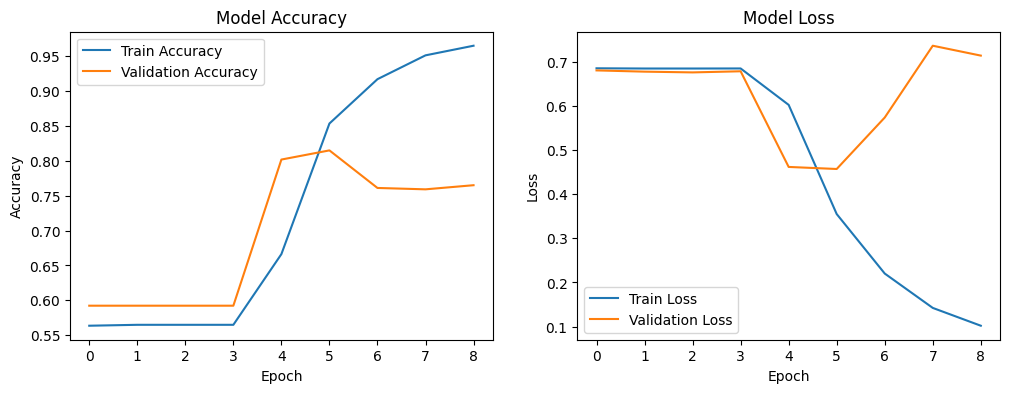

In [48]:
plot_history(tuned_history)

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


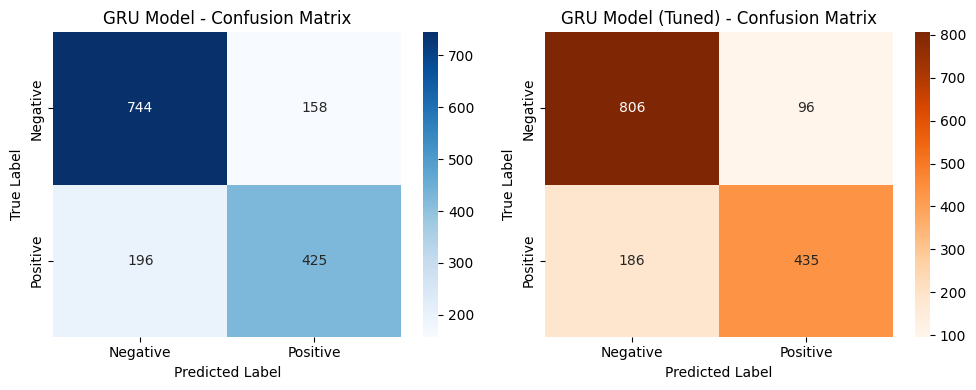

In [52]:
y_pred_rnn = (baseline_model.predict(X_val) > 0.5).astype(int).flatten()
y_pred_tuned = (tuned_model.predict(X_val) > 0.5).astype(int).flatten()

plot_confusion_matrices_comparison(
    y_val, y_pred_rnn, y_val, y_pred_tuned,
    model_name_1="GRU Model", model_name_2="GRU Model (Tuned)"
)

F1 Score improves from 0.69 to 0.75.

In [53]:
f1_model_tuned = f1_score(y_val, y_pred_tuned)

print(f"F1 Score (CNN Model): {f1_model_tuned:.4f}")

F1 Score (CNN Model): 0.7552


It was possible to avoid passing the optimal point by reducing the learning rate as hyperparameter tuning. But it was not possible to make the learning converge smoothly.

# Conclusion

* In this report, I chose RNN (with GRU), CNN as my model and explained why.
  * Through this, we were able to rearrange the structure and issues of RNN, and the outline of Gated RNN and why it can improve gradient loss.
* I trained each model and compared the results, and found that the RNN performed reasonably well, but the CNN could not be trained well. From this result, we confirmed that RNN has a more natural structure for text data.
* I pointed out that the reason why the CNN did not learn well may be the incompatibility between embedding optimization and convolution, and discussed the possibility of using pre-trained word embedding to improve the performance.
* Hyperparameter tuning resulted in a small performance improvement, but issues remained in the training stability of the model and the basic performance.
* We can pursue even higher performance by using more expressive models (BERT, Transformer, etc.) than simple GRUs.

# Generate Submission

In [57]:
submission = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')
test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

test_df['cleaned_text'] = test_df['text'].apply(clean_text)
X_test = generate_input(test_df["cleaned_text"], tokenizer)

submission['target'] = (tuned_model.predict(X_test) > 0.5).astype(int)

submission.to_csv('submission.csv', index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


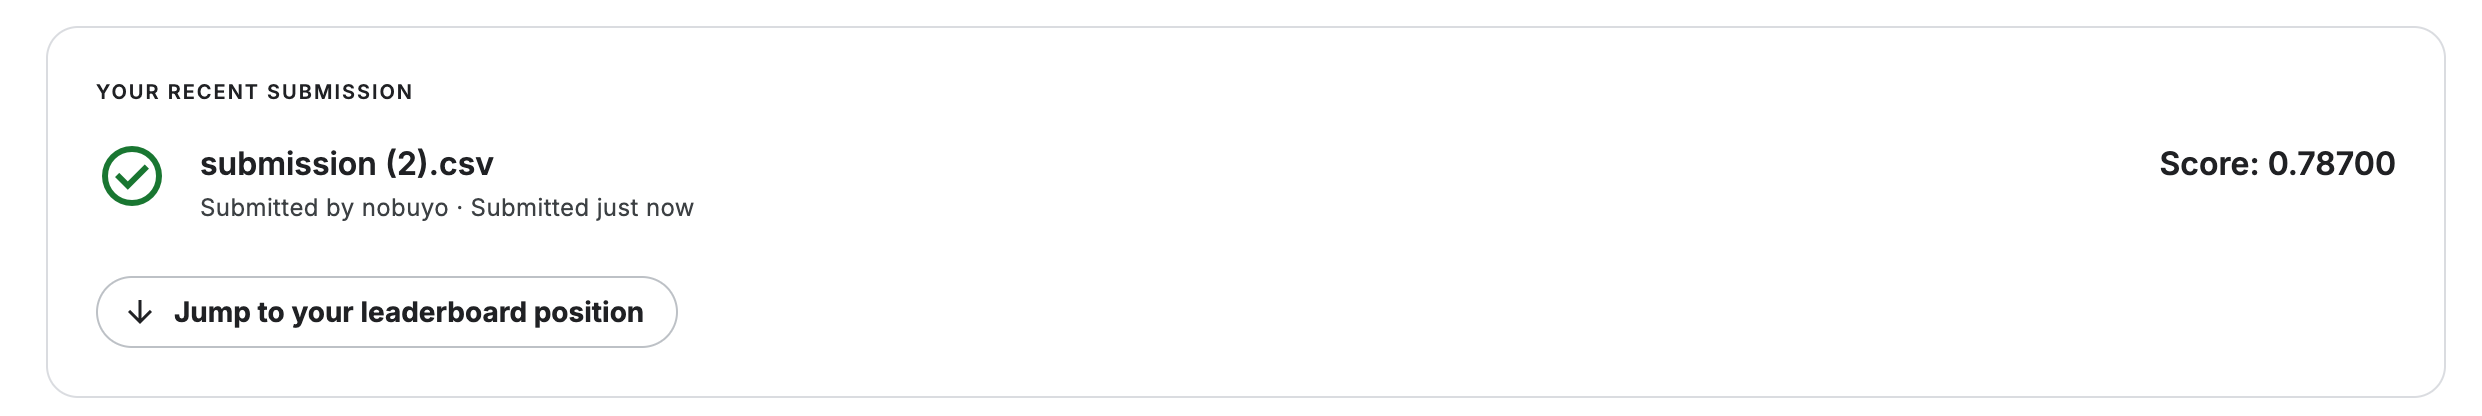